In [ ]:
import tensorflow as tf
import keras
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

import os, shutil

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn import metrics

**I have manually created related rare events images. So I just changed the cats and dogs directory names to cats_1 and dogs_1**

In [ ]:
base_dir = '/Users/mustafa/Desktop/NJIT/Classes/Intro_to_Artificial_Intelligence/Python/Assignment_3/dogscats/'
train_dir = os.path.join(base_dir, 'train_10')
train_cats_dir = os.path.join(base_dir, 'train_10', 'cats_10') # cats are %10 of total
train_dogs_dir = os.path.join(base_dir, 'train_10', 'dogs_10')
validation_dir = os.path.join(base_dir, 'validation_10')
test_dir = os.path.join(base_dir, 'test_10')

In [ ]:
# set-up model with augmented images
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# compile model
model.compile(loss='binary_crossentropy',
              # legacy is used for M1 chip. lr turned into learning_rate
              optimizer=optimizers.legacy.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [ ]:
# augment training data
# Note that the validation data should not be augmented!
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

In [ ]:
# Image pre-processing
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# read train data set from file
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
# read validation data set from file
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

In [ ]:
# fit data to model
history = model.fit(
      train_generator,
      steps_per_epoch=2000//train_generator.batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=1000//validation_generator.batch_size)

In [ ]:
# save model
model.save('cats_and_dogs_10_percent.h5')

In [ ]:
# acquire accuracy and loss data
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(len(acc))

# plot training accuracy and validation accuracy - epochs
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# plot validation accuracy and validation accuracy - epochs
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**For the 10 percent case the outputs are below.**

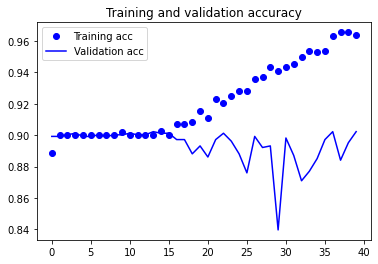

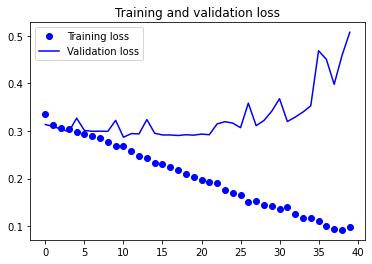

**For the 1 percent case the outputs are below.**

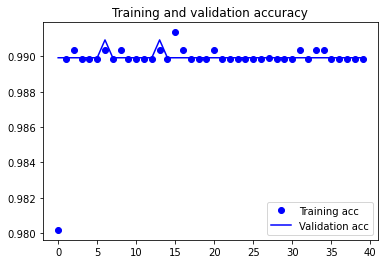

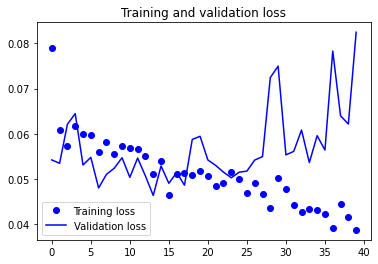

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

# read test data from file
test_generator = test_datagen.flow_from_directory(
        # This is the target directory
        test_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Range of threshold values
thresholds = np.linspace(0, 1, 100)

# Generate predictions
test_generator.reset()
y_true = []
y_scores = []

for i in range(1000 // test_generator.batch_size):
    x_val, y_val = test_generator.next()
    y_true.extend(y_val)
    y_scores.extend(model.predict(x_val).flatten())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Create lists to storage
tpr_values = []
fpr_values = []
precision_values = []
recall_values = []

# Calculate TPR, FPR, precision, and recall for each threshold
for threshold in thresholds:
    y_pred_binary = (y_scores >= threshold).astype(int)

    TP = np.sum((y_true == 1) & (y_pred_binary == 1))
    FN = np.sum((y_true == 1) & (y_pred_binary == 0))
    TN = np.sum((y_true == 0) & (y_pred_binary == 0))
    FP = np.sum((y_true == 0) & (y_pred_binary == 1))

    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    tpr_values.append(TPR)
    fpr_values.append(FPR)
    precision_values.append(precision)
    recall_values.append(recall)

plt.figure(figsize=(12, 6))

#--------

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr_values, tpr_values, label='ROC curve', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower left')
plt.grid()

# Plot precision-recall curve
plt.subplot(1, 2, 2)
plt.plot(recall_values, precision_values, label='Precision-Recall curve', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()

# Calculate confusion matrix with a threshold of 0.5
y_pred_cm = (y_scores >= 0.5).astype(int)
TP = np.sum((y_true == 1) & (y_pred_cm == 1))
FN = np.sum((y_true == 1) & (y_pred_cm == 0))
TN = np.sum((y_true == 0) & (y_pred_cm == 0))
FP = np.sum((y_true == 0) & (y_pred_cm == 1))

# Print the confusion matrix
confusion_matrix = np.array([[TN, FP], [FN, TP]])
print("Confusion Matrix (Threshold = 0.5):")
print(confusion_matrix)

# turn table into confusion matrix display
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

# plot confusion matrix
cm_display.plot()
plt.show()

**For the 10 percent case the outputs are below.**

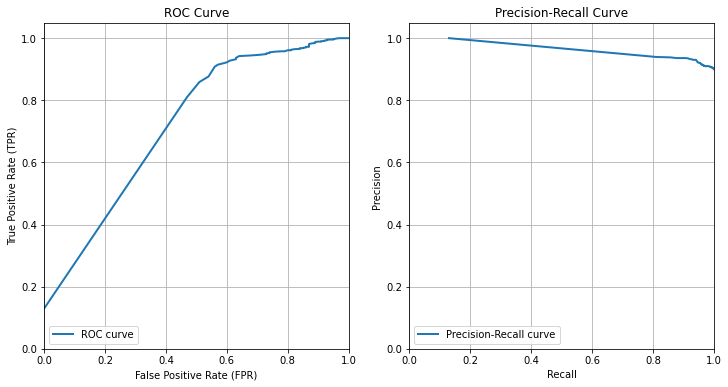

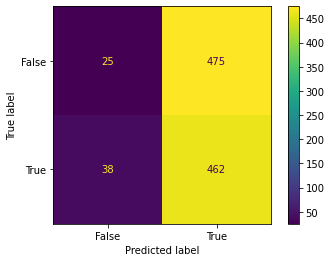

**For the 1 percent case the outputs are below.**

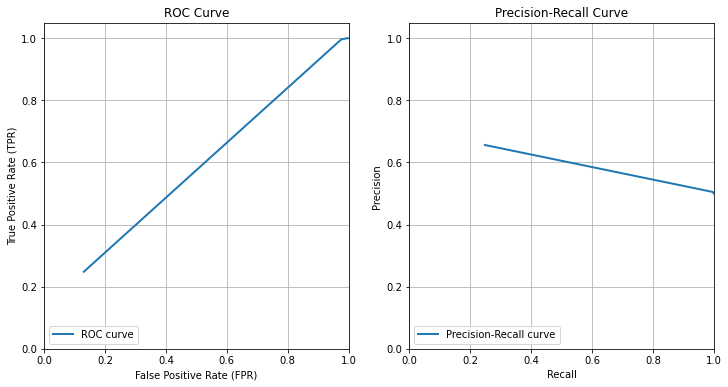

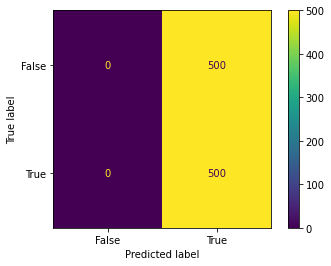